
# Módulo de productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

In [4]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

# Función Productividad de pozos

In [15]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                                'expon',
                                'gamma',
                                'lognorm',
                                'norm',
                                'pearson3',
                                'triang',
                                'uniform',
                                'weibull_min', 
                                'weibull_max']
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/pozos/mx_benchmark.csv',

                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['Dias Produciendo']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5))
        plt.show()
    
    results=pd.DataFrame()
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                  calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 12, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,"Hyperbolic_Predicted", "Exponential_Predicted", "Harmonic_Predicted"]
        x_variable='days_online'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')


    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

'Numero de datos en BD: 2838332'

Nombre de Campo: ZAAP


'Numero de datos para ZAAP: 8660'

'Número de pozos en ZAAP: 81'

array(['ZAAP-2051', 'ZAAP-2032', 'ZAAP-3D', 'ZAAP-5D', 'ZAAP-1001',
       'ZAAP-106', 'ZAAP-7DA', 'ZAAP-27D', 'ZAAP-22D', 'ZAAP-95',
       'ZAAP-108', 'ZAAP-23D', 'ZAAP-2031', 'ZAAP-20', 'ZAAP-36',
       'ZAAP-25D', 'ZAAP-18', 'ZAAP-24', 'ZAAP-38', 'ZAAP-4', 'ZAAP-48',
       'ZAAP-10', 'ZAAP-12', 'ZAAP-26', 'ZAAP-16', 'ZAAP-32', 'ZAAP-128',
       'ZAAP-22', 'ZAAP-25', 'ZAAP-27', 'ZAAP-8', 'ZAAP-2', 'ZAAP-58',
       'ZAAP-14', 'ZAAP-28', 'ZAAP-30', 'ZAAP-41', 'ZAAP-9', 'ZAAP-6D',
       'ZAAP-43', 'ZAAP-118', 'ZAAP-6', 'ZAAP-44', 'ZAAP-1003', 'ZAAP-11',
       'ZAAP-5', 'ZAAP-210', 'ZAAP-111', 'ZAAP-208', 'ZAAP-21',
       'ZAAP-110D', 'ZAAP-29D', 'ZAAP-114D', 'ZAAP-103', 'ZAAP-31D',
       'ZAAP-15', 'ZAAP-33D', 'ZAAP-116D', 'ZAAP-50', 'ZAAP-34',
       'ZAAP-35', 'ZAAP-126', 'ZAAP-19', 'ZAAP-46D', 'ZAAP-51', 'ZAAP-90',
       'ZAAP-52', 'ZAAP-54', 'ZAAP-68', 'ZAAP-42', 'ZAAP-62', 'ZAAP-78',
       'ZAAP-72DES', 'ZAAP-56DES', 'ZAAP-66DES', 'ZAAP-53DES',
       'ZAAP-115DES', 'ZAA

'Percentiles y estadistica descriptiva: '

0.10   1.78
0.50   5.21
0.90   9.03
Name: aceite_Mbd, dtype: float64

,Unnamed: 0,aceite_Mbd,agua_Mbd,condensado_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd
count,"8,660.00","8,660.00","8,660.00","8,660.00","8,660.00","8,660.00"
mean,"573,417.32",5.39,0.02,0.00,2.59,0.00
std,"96,183.52",2.90,0.13,0.00,3.47,0.00
min,"247,631.00",0.00,0.00,0.00,0.00,0.00
25%,"510,487.75",3.24,0.00,0.00,1.09,0.00
50%,"581,091.50",5.21,0.00,0.00,1.84,0.00
75%,"654,395.25",7.25,0.00,0.00,2.82,0.00
max,"714,403.00",17.01,2.57,0.00,53.74,0.00


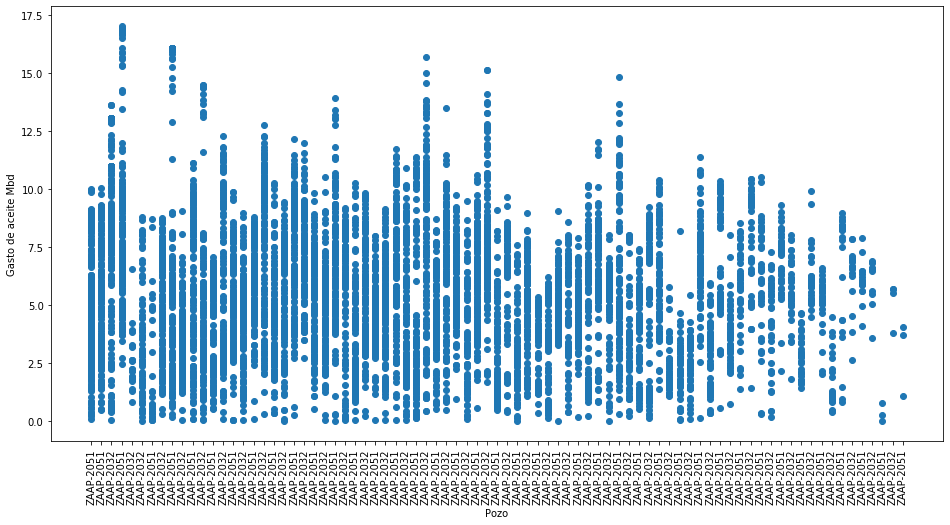

C:\Users\elias\Anaconda\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\elias\Anaconda\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


('weibull_min', 0.001444128327957998)

C:\Users\elias\Anaconda\lib\site-packages\ipykernel_launcher.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Exponential Fit Curve-fitted Variables: qi=0.521062582594345, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.9583869999999997, b=6.36558600630526e-14, di=7.508094105967711e-25
Harmonic Fit Curve-fitted Variables: qi=3.958386999999995, di=9.868185099701598e-20


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


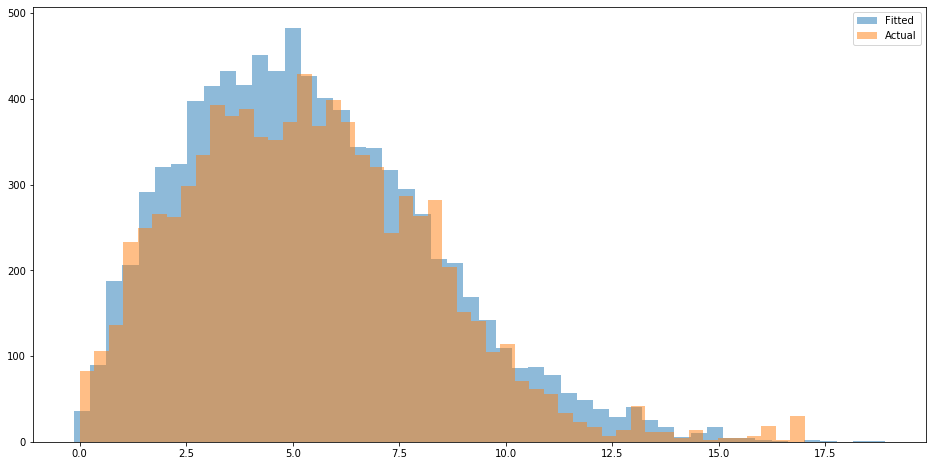

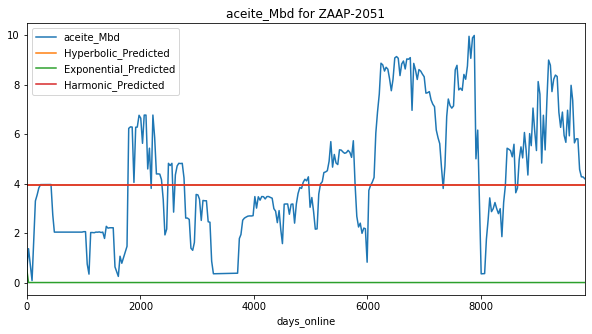

Exponential Fit Curve-fitted Variables: qi=2.7337166508458264, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.7550329999999996, b=1.9999999999999998, di=1.5734368694661569e-21
Harmonic Fit Curve-fitted Variables: qi=2.7550329999999996, di=4.776357143608732e-24


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


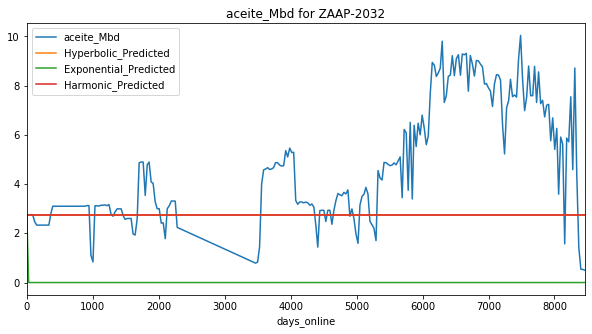

Exponential Fit Curve-fitted Variables: qi=9.101566343681531, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=12.038458257253646, b=0.17309328702724966, di=0.00012459850818126417
Harmonic Fit Curve-fitted Variables: qi=12.133332999999505, di=0.00015853194110540804


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


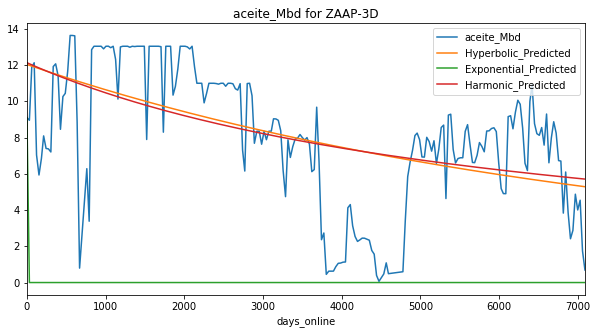

Exponential Fit Curve-fitted Variables: qi=6.482902424963514, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=9.3880649999999, b=2.544215167259002e-10, di=3.473170776267117e-05
Harmonic Fit Curve-fitted Variables: qi=9.388064999998479, di=3.5385362789804357e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


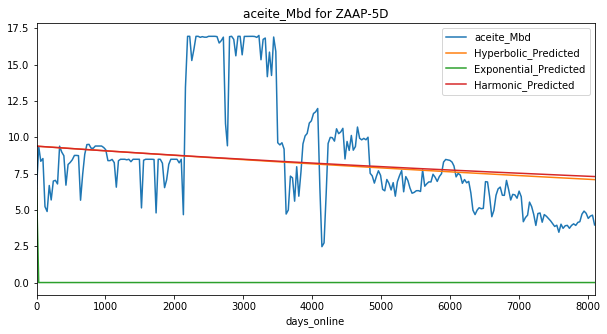

Exponential Fit Curve-fitted Variables: qi=6.56142449798584, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.643355141176132, b=1.9999999999999998, di=0.007154535361508975
Harmonic Fit Curve-fitted Variables: qi=4.901260688855646, di=0.0029842212020256237


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


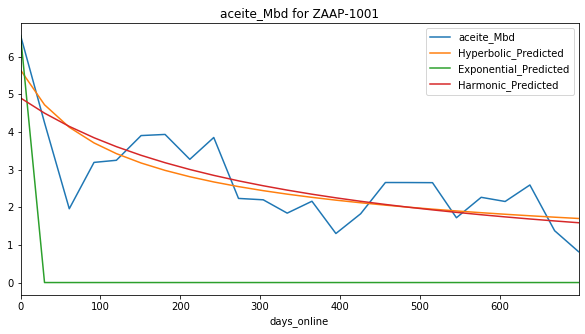

Exponential Fit Curve-fitted Variables: qi=2.798773999086986, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.3616925697999993, b=1.9999999999999998, di=1.6632433674905364e-24
Harmonic Fit Curve-fitted Variables: qi=3.3616925640643855, di=3.9752728779907696e-18


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


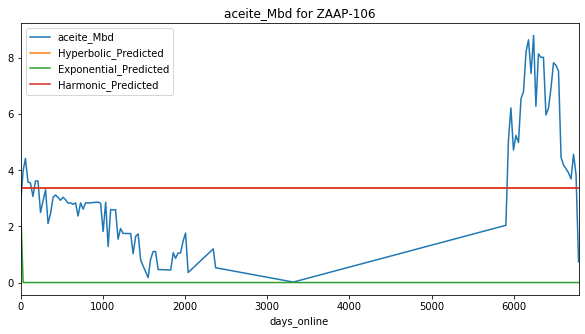

Exponential Fit Curve-fitted Variables: qi=0.06858110035806854, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.9136254046685526, b=2.1046156449915363e-09, di=0.00017402909294202595
Harmonic Fit Curve-fitted Variables: qi=2.837441877613171, di=0.00016556292660946687


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


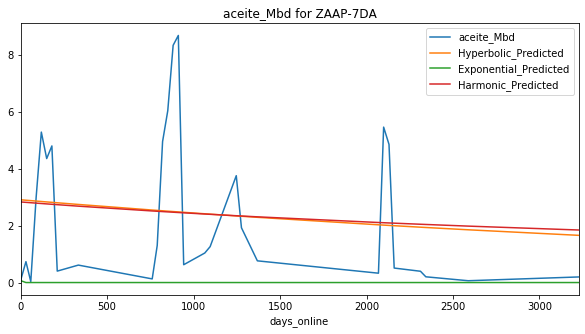

Exponential Fit Curve-fitted Variables: qi=2.409806845539369, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.525117974148773, b=1.7949964880746275e-12, di=7.317018823446497e-05
Harmonic Fit Curve-fitted Variables: qi=7.302658233547345, di=8.15561144369417e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


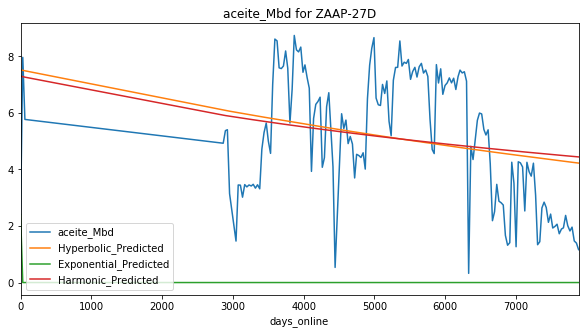

Exponential Fit Curve-fitted Variables: qi=8.13797377074807, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=16.066439999999997, b=0.3378633410795413, di=0.0005363875795862758
Harmonic Fit Curve-fitted Variables: qi=16.066439999999997, di=0.0007918872929296877


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


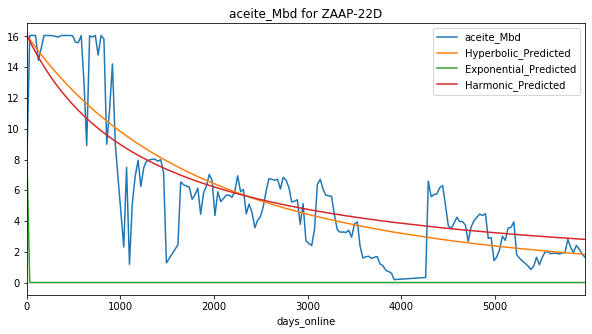

Exponential Fit Curve-fitted Variables: qi=0.07419905404530341, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.4260569999999997, b=1.9999970027708234, di=4.5845204387973134e-21
Harmonic Fit Curve-fitted Variables: qi=2.4260569999999997, di=7.197686654632812e-21


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


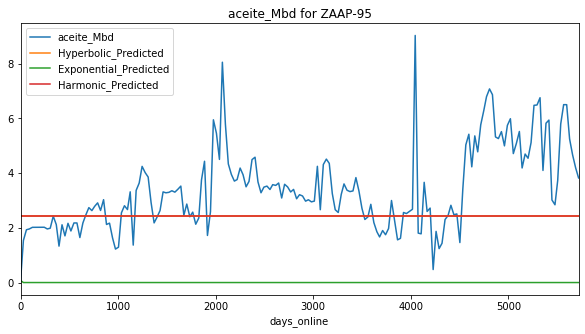

Exponential Fit Curve-fitted Variables: qi=1.3293795316257992, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.6011599999999966, b=1.9999999999999998, di=1.170521703681608e-16
Harmonic Fit Curve-fitted Variables: qi=1.6011599999999997, di=1.85950749385959e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


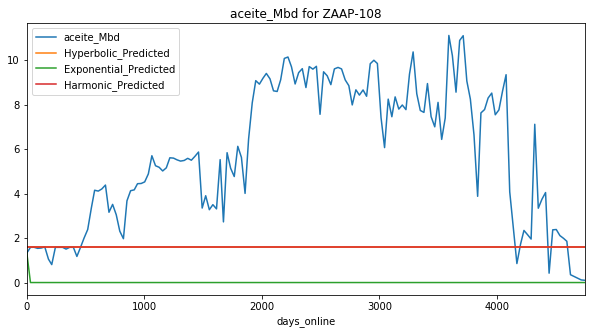

Exponential Fit Curve-fitted Variables: qi=1.0273902312732, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=13.524794341682869, b=1.3379846888076083, di=0.0010295871550993659
Harmonic Fit Curve-fitted Variables: qi=12.930993956493891, di=0.0007680095911026856


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


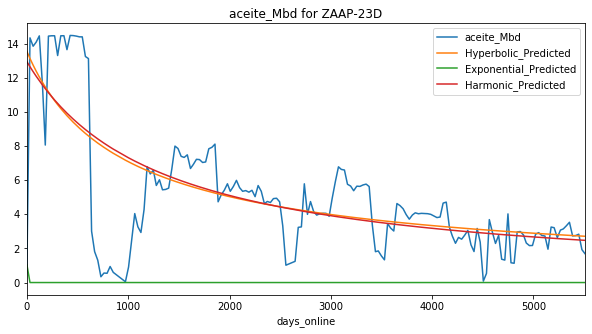

Exponential Fit Curve-fitted Variables: qi=1.3966687776230295, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=1.7521149999999999, b=1.5752781723499254e-07, di=2.834638277008706e-19
Harmonic Fit Curve-fitted Variables: qi=1.7521149999999999, di=1.2309451198295983e-22


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


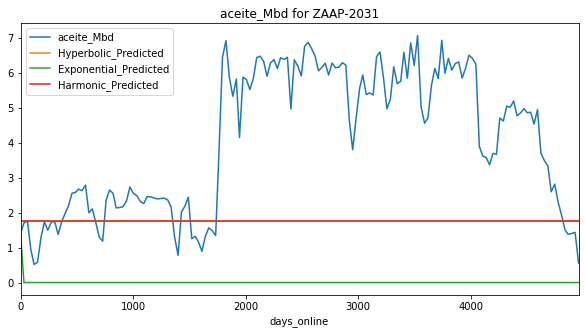

Exponential Fit Curve-fitted Variables: qi=3.924835000198481, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=10.158026999999656, b=1.4845549834184097e-08, di=0.0002413180026812171
Harmonic Fit Curve-fitted Variables: qi=10.158026999999805, di=0.00033776641230547213


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


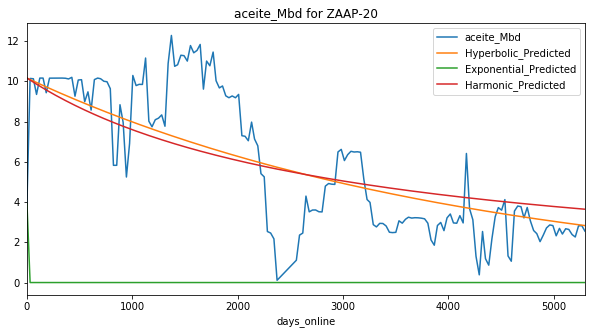

Exponential Fit Curve-fitted Variables: qi=2.6599770500821327, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.383009999966946, b=8.206380636801615e-08, di=6.187703034730134e-05
Harmonic Fit Curve-fitted Variables: qi=5.383009999999761, di=6.517011284915786e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


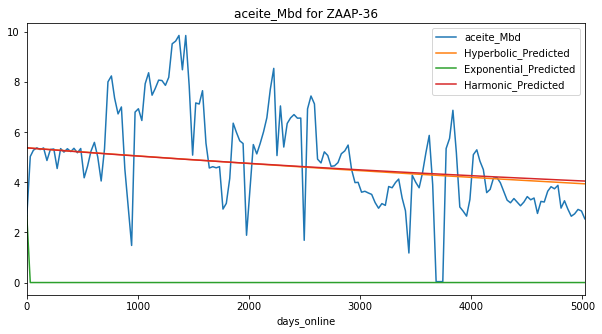

Exponential Fit Curve-fitted Variables: qi=5.455727994670012, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.252201527849602, b=2.407002458513609e-09, di=0.00014116453062048905
Harmonic Fit Curve-fitted Variables: qi=6.210369879450553, di=0.00016798439237640175


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


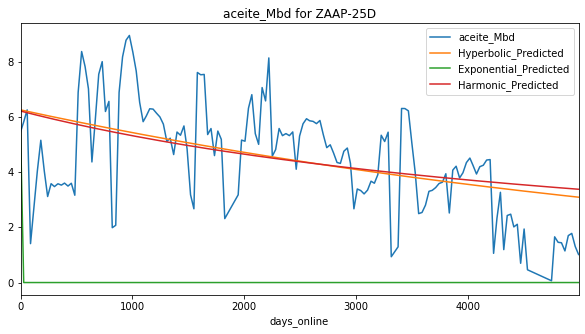

Exponential Fit Curve-fitted Variables: qi=0.11212817969210692, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.966148980294921, b=2.6536054910722418e-08, di=6.6493791377422266e-18
Harmonic Fit Curve-fitted Variables: qi=5.966148987402583, di=4.4262861307286025e-20


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


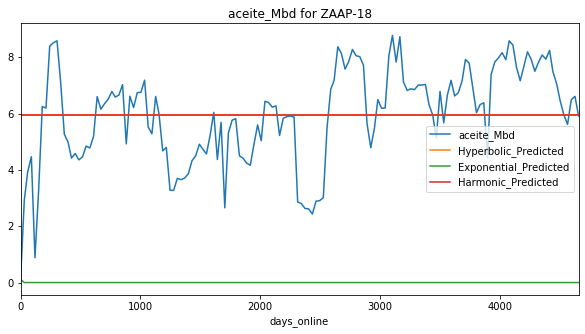

Exponential Fit Curve-fitted Variables: qi=0.3268756440976686, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=8.178696122188043, b=1.2961096092164355e-08, di=2.8008212434864045e-05
Harmonic Fit Curve-fitted Variables: qi=8.092603818304648, di=2.4154910921944536e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


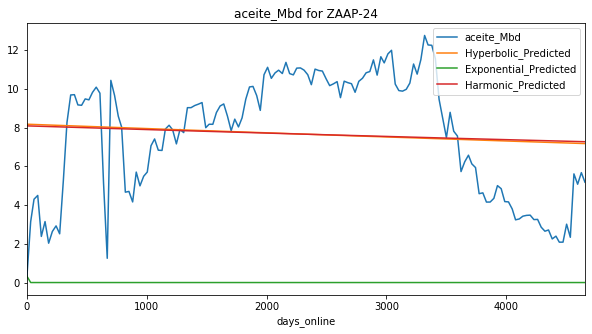

Exponential Fit Curve-fitted Variables: qi=1.2078740620231885, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.1325156551561255, b=1.2944844386641436, di=0.00019217488502059466
Harmonic Fit Curve-fitted Variables: qi=6.0966675324541475, di=0.0001764651352315692


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


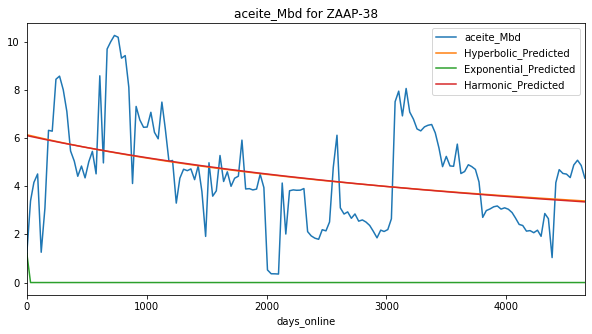

Exponential Fit Curve-fitted Variables: qi=2.5463550010901845, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.879261999649931, b=1.515006175154733e-10, di=0.00012123594922117787
Harmonic Fit Curve-fitted Variables: qi=6.879261999999993, di=0.00013826862910300475


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


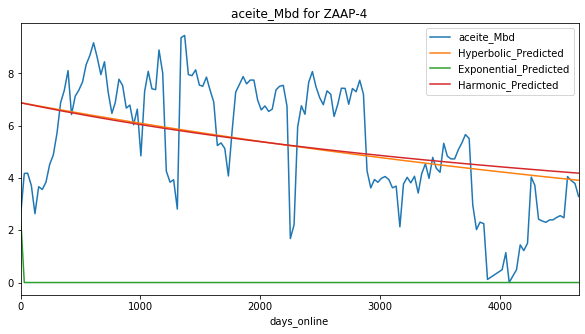

Exponential Fit Curve-fitted Variables: qi=0.2814206259294588, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.505825999999999, b=1.9999999999999998, di=1.9139194547481674e-20
Harmonic Fit Curve-fitted Variables: qi=6.5058259999926085, di=1.0285730761039433e-16


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


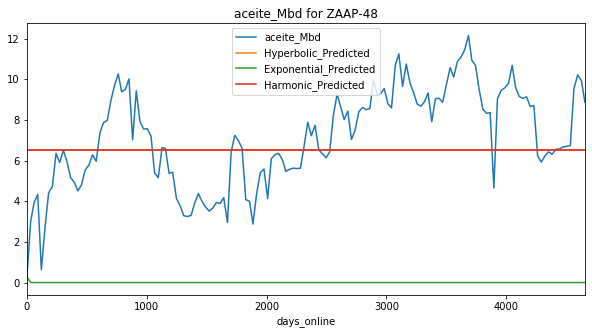

Exponential Fit Curve-fitted Variables: qi=3.501846060206541, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.084818999999963, b=1.9999712493915203, di=3.264556524972206e-19
Harmonic Fit Curve-fitted Variables: qi=7.084818999846407, di=2.504096506151846e-16


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


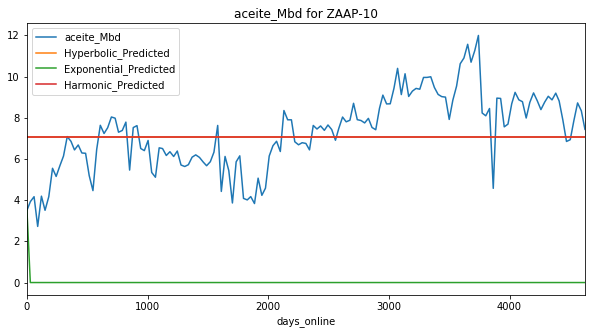

Exponential Fit Curve-fitted Variables: qi=3.244548007469586, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.734240818748079, b=6.313692383544013e-08, di=9.375475504275537e-05
Harmonic Fit Curve-fitted Variables: qi=6.656426839050052, di=0.00010034226711533575


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


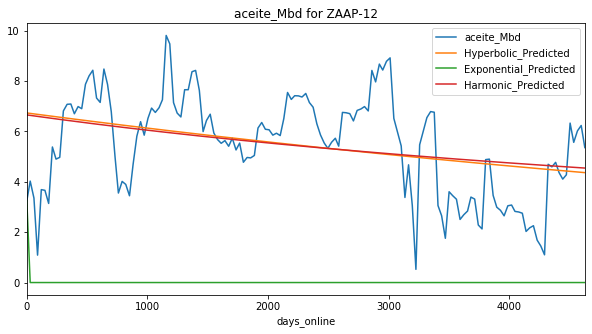

Exponential Fit Curve-fitted Variables: qi=0.06266681570845957, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.507917863284563, b=2.1962716086198968e-08, di=0.00014200036450721636
Harmonic Fit Curve-fitted Variables: qi=6.437870460094688, di=0.0001653387886461501


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


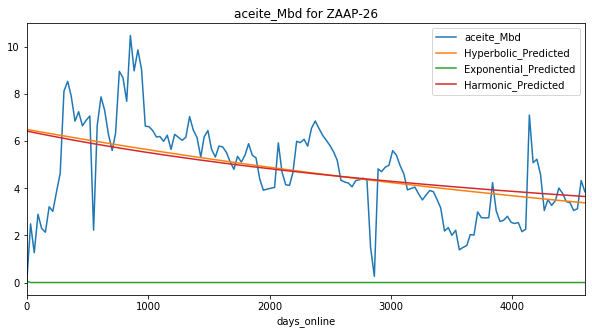

Exponential Fit Curve-fitted Variables: qi=0.33344952418048635, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.392362999664859, b=1.9999999999996845, di=1.2317641041647243e-18
Harmonic Fit Curve-fitted Variables: qi=5.392362999999861, di=1.395222342591854e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


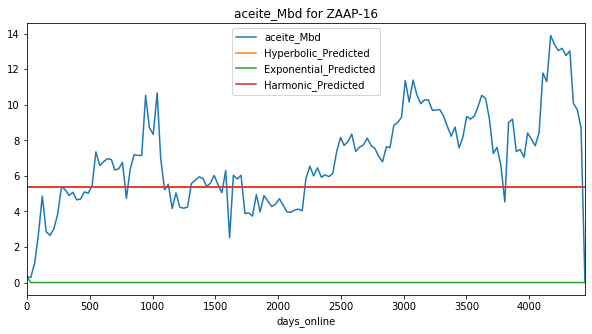

Exponential Fit Curve-fitted Variables: qi=0.1960327681486055, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.948927292631247, b=5.172276686350781e-07, di=1.5435890408629532e-05
Harmonic Fit Curve-fitted Variables: qi=5.934836755473827, di=1.4485687350360054e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


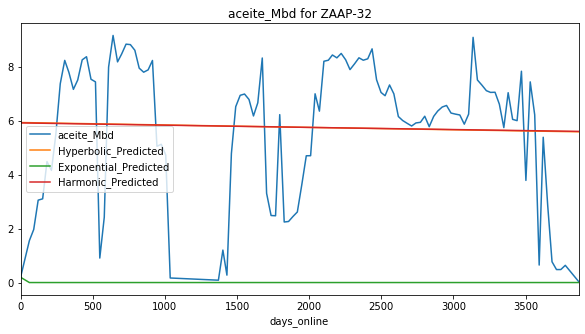

Exponential Fit Curve-fitted Variables: qi=0.04363813076368958, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.44447163242127, b=1.173556925215171e-07, di=0.0003062572694180969
Harmonic Fit Curve-fitted Variables: qi=6.375742336640236, di=0.0004317463375450656


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


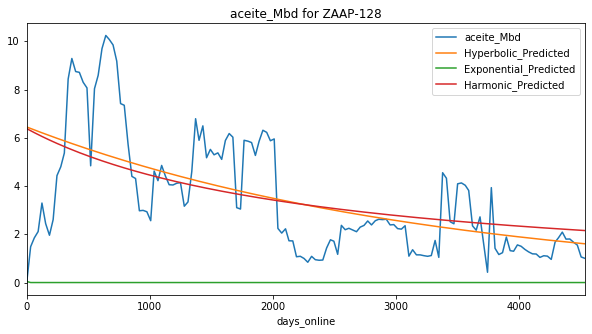

Exponential Fit Curve-fitted Variables: qi=0.21700158405163525, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.9388076379854295, b=1.070735784379661e-13, di=2.004365447067959e-05
Harmonic Fit Curve-fitted Variables: qi=5.900544503231562, di=1.9237549839291856e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


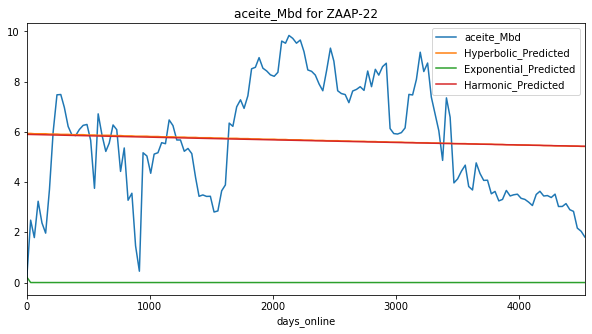

Exponential Fit Curve-fitted Variables: qi=0.03448730814729131, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.7061222743205, b=2.6911477001135238e-08, di=1.3814725956356058e-05
Harmonic Fit Curve-fitted Variables: qi=4.701868925627749, di=1.3682969520668213e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


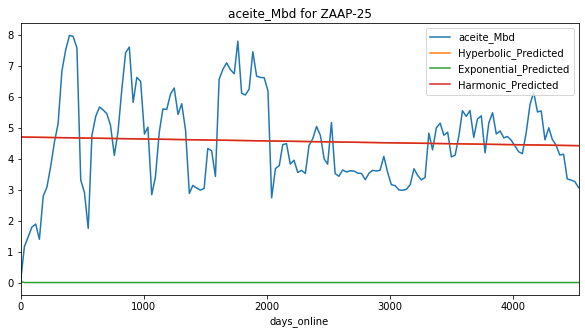

Exponential Fit Curve-fitted Variables: qi=0.03432002558911268, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.847010047445078, b=1.9984555698322428, di=3.797383174046451e-20
Harmonic Fit Curve-fitted Variables: qi=4.847009542259032, di=8.020572907336982e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


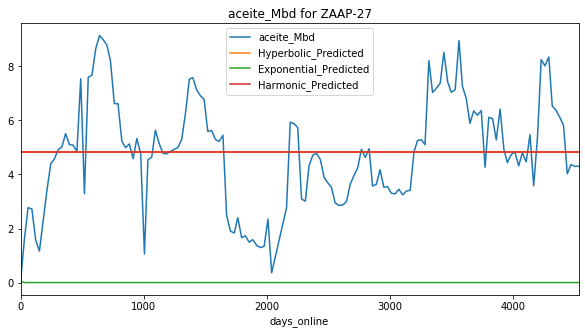

Exponential Fit Curve-fitted Variables: qi=0.04938774585320272, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.8048606335472455, b=1.9999999999999998, di=9.722820032097935e-20
Harmonic Fit Curve-fitted Variables: qi=6.8048606301883, di=9.025301427320873e-18


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


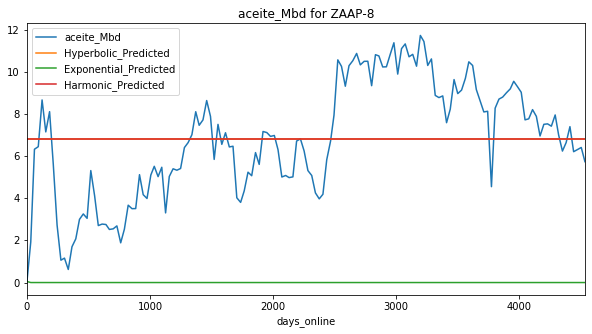

Exponential Fit Curve-fitted Variables: qi=0.20653899026473088, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.868951072165284, b=1.9654580052684631, di=0.00022691732691163598
Harmonic Fit Curve-fitted Variables: qi=6.714049839108815, di=0.0001682668615517324


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


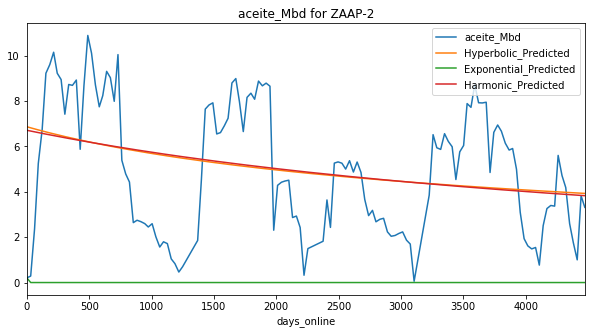

Exponential Fit Curve-fitted Variables: qi=1.739414650554464, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.3152289999999995, b=1.9999999999999998, di=4.6856962016904235e-19
Harmonic Fit Curve-fitted Variables: qi=3.3152289999992957, di=7.62954671621432e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


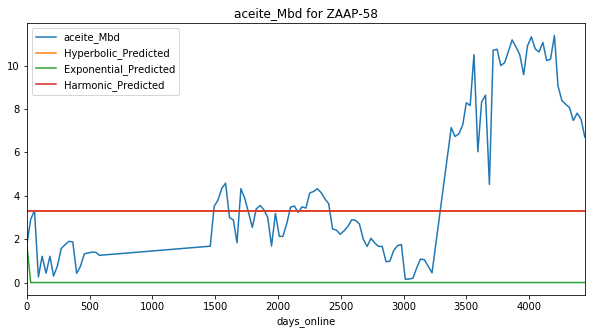

Exponential Fit Curve-fitted Variables: qi=0.4621392119403908, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=8.576914999788965, b=4.233899491016506e-08, di=6.223592997924066e-05
Harmonic Fit Curve-fitted Variables: qi=8.576914999999994, di=6.168090503972e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


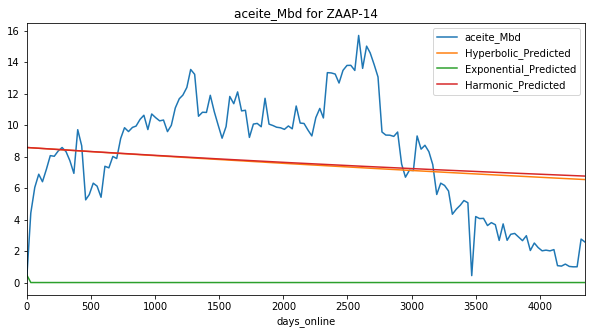

Exponential Fit Curve-fitted Variables: qi=1.7824930009594873, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.473875989723739, b=1.999999999999814, di=8.148242564877997e-16
Harmonic Fit Curve-fitted Variables: qi=4.473875983496432, di=2.914481849042338e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


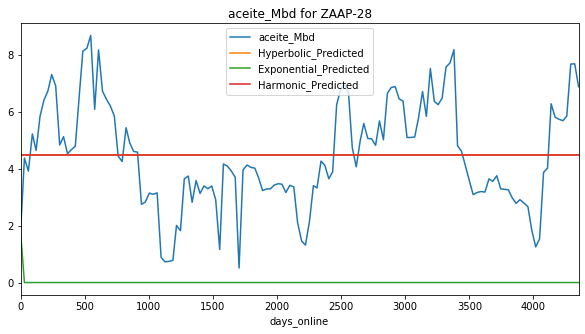

Exponential Fit Curve-fitted Variables: qi=0.4999710720236929, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.545902272985609, b=6.893503459171058e-07, di=1.6325731267781507e-17
Harmonic Fit Curve-fitted Variables: qi=6.54590228386014, di=5.884643705179449e-24


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


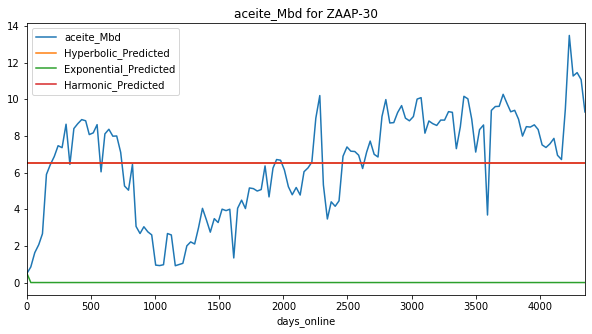

Exponential Fit Curve-fitted Variables: qi=0.9566612994063258, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.756585602837738, b=1.9999999999999998, di=2.4173740551178094e-16
Harmonic Fit Curve-fitted Variables: qi=5.756585604972028, di=5.879567207760648e-23


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


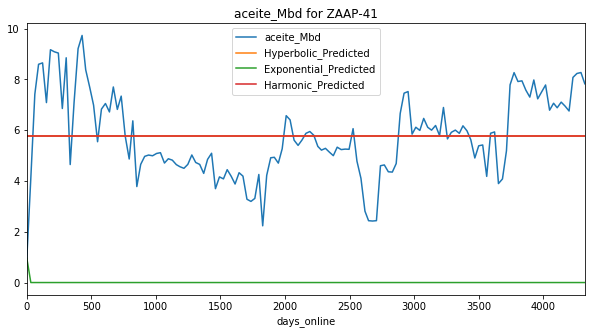

Exponential Fit Curve-fitted Variables: qi=0.2082421261397867, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.442515409502884, b=1.9552659793356572e-08, di=0.0004103806621575491
Harmonic Fit Curve-fitted Variables: qi=6.363517616217422, di=0.0005359460945971847


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


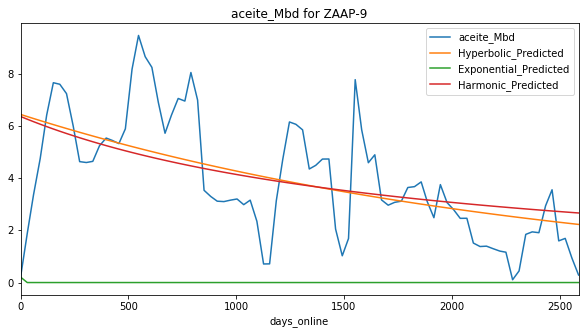

Exponential Fit Curve-fitted Variables: qi=0.5807560300787448, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.0480349566136, b=3.18195379846444e-10, di=6.682446745671422e-05
Harmonic Fit Curve-fitted Variables: qi=7.007522419796383, di=6.973857313105369e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


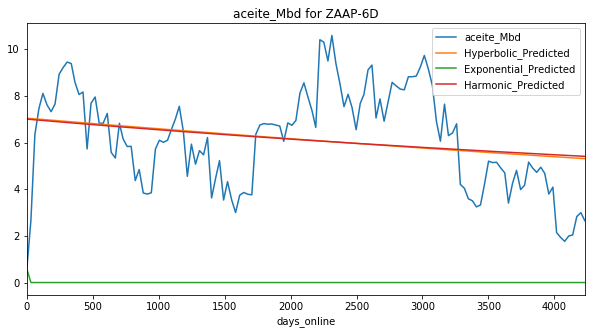

Exponential Fit Curve-fitted Variables: qi=1.693231542710917, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.997934924590015, b=1.4079009396095188e-06, di=7.020909206569714e-17
Harmonic Fit Curve-fitted Variables: qi=7.997934948021583, di=2.945785938039776e-24


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


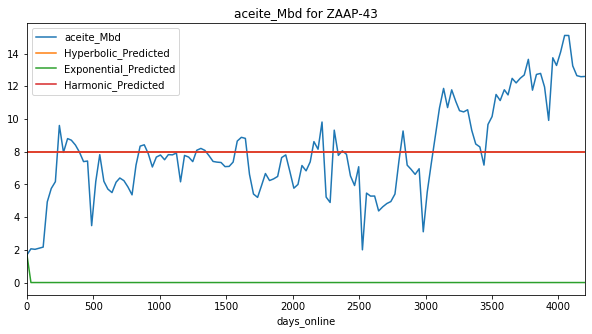

Exponential Fit Curve-fitted Variables: qi=0.6022720075937357, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.487522864649658, b=2.505500482821126e-08, di=0.0003468897564037862
Harmonic Fit Curve-fitted Variables: qi=5.473086046422831, di=0.0005008882730756466


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


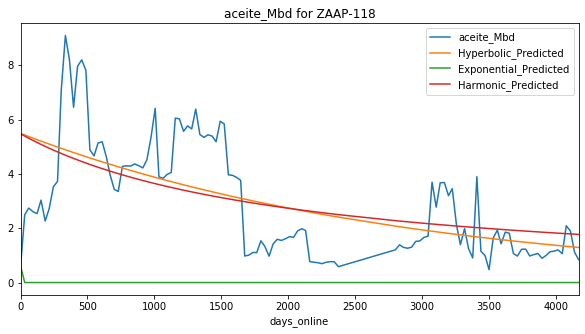

Exponential Fit Curve-fitted Variables: qi=1.1366280427001139, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.492123999999999, b=3.37665670824272e-06, di=9.622143401126418e-19
Harmonic Fit Curve-fitted Variables: qi=5.492123999998245, di=1.828925731474835e-15


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


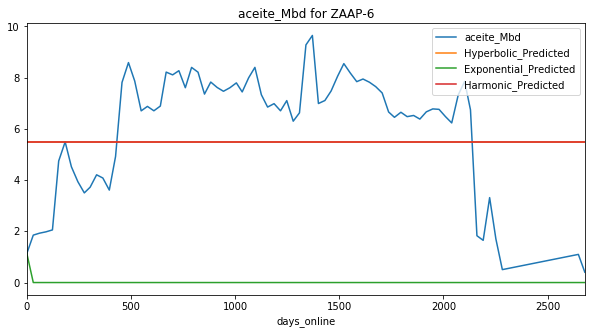

Exponential Fit Curve-fitted Variables: qi=0.12819922343872345, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.1921948750905167, b=8.709360563679582e-06, di=4.6691397156260164e-14
Harmonic Fit Curve-fitted Variables: qi=3.192194834764384, di=1.1199887762009387e-20


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


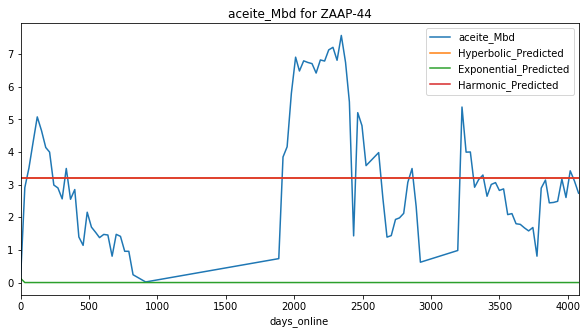

Exponential Fit Curve-fitted Variables: qi=2.5276365889067174, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.305429086905175, b=1.9999999999997198, di=0.00016034972713638038
Harmonic Fit Curve-fitted Variables: qi=6.1877577403564565, di=0.0001241651416417953


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


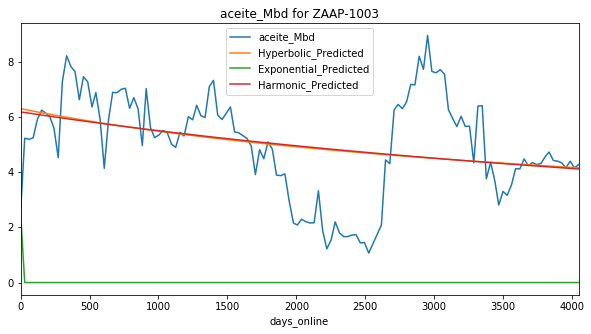

Exponential Fit Curve-fitted Variables: qi=2.2413620512127856, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.209899596783046, b=2.2310480557515447e-07, di=0.00023256623031332301
Harmonic Fit Curve-fitted Variables: qi=4.132292979888384, di=0.00024324703516482373


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


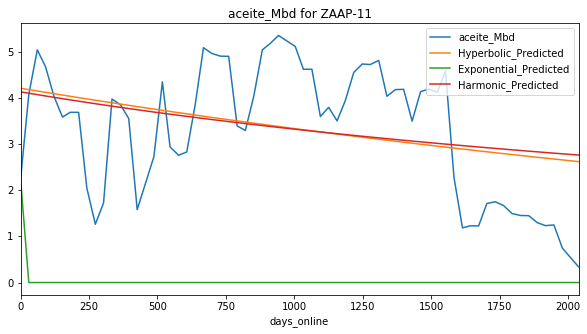

Exponential Fit Curve-fitted Variables: qi=3.2535549831999617, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.946516999437189, b=8.272305919199497e-11, di=0.0005333687006987476
Harmonic Fit Curve-fitted Variables: qi=5.946516999999986, di=0.000780592663878545


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


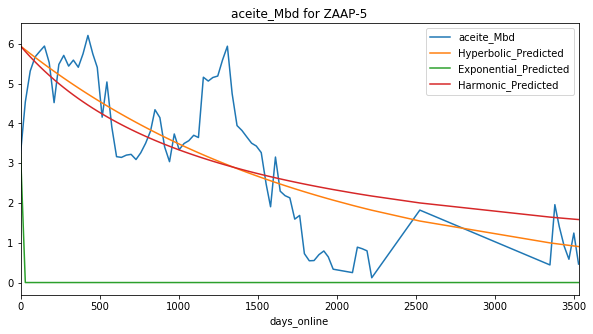

Exponential Fit Curve-fitted Variables: qi=0.018894143686416735, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.009654252159255, b=1.998708540982505, di=1.6717593167350756e-13
Harmonic Fit Curve-fitted Variables: qi=5.00965364772179, di=7.756241164994359e-18


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


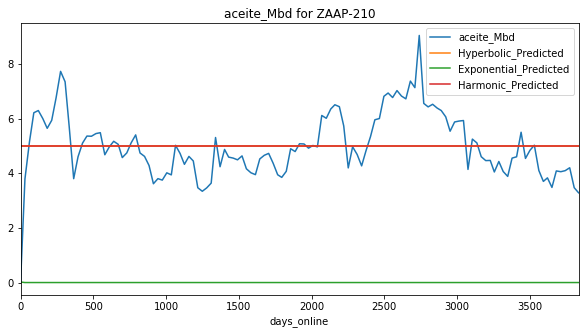

Exponential Fit Curve-fitted Variables: qi=0.3871071124329998, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.56118860443842, b=1.0738401408650753e-10, di=0.00032656810486318325
Harmonic Fit Curve-fitted Variables: qi=6.5150837170840745, di=0.0003933909240710032


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


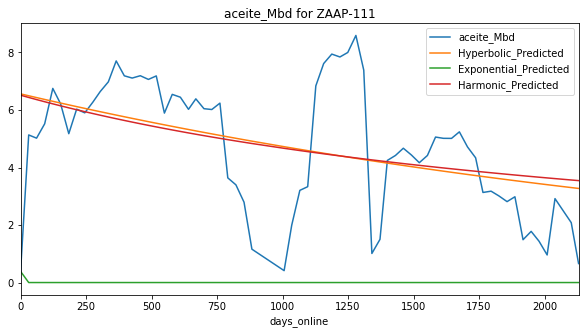

Exponential Fit Curve-fitted Variables: qi=0.17356535997444497, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=4.141245999999999, b=3.4299531659343074e-07, di=2.398887060567402e-18
Harmonic Fit Curve-fitted Variables: qi=4.141245999999308, di=1.1784817770739254e-15


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


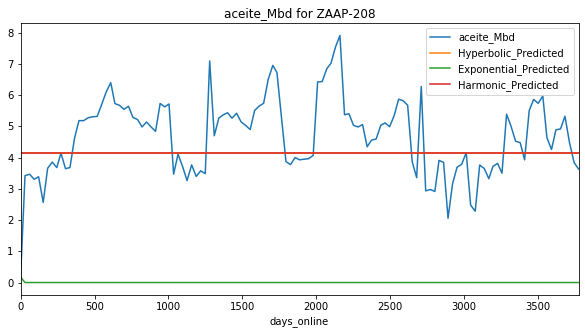

Exponential Fit Curve-fitted Variables: qi=2.060017001134239, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.917679356216078, b=3.812374488670275e-10, di=0.0003102205439514489
Harmonic Fit Curve-fitted Variables: qi=7.740504048639229, di=0.00038585787956112324


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


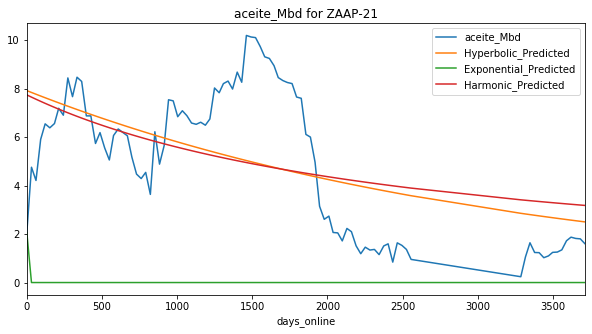

Exponential Fit Curve-fitted Variables: qi=3.726187323746804, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=9.369261935662628, b=0.841236663724474, di=0.0002677283368902797
Harmonic Fit Curve-fitted Variables: qi=9.411092818020263, di=0.0002826742426012833


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


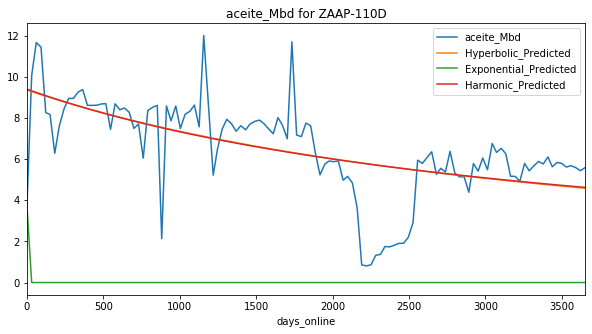

Exponential Fit Curve-fitted Variables: qi=0.42431301424498197, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.247251526395257, b=5.527523474366383e-09, di=0.00014057153624620557
Harmonic Fit Curve-fitted Variables: qi=6.171158994437508, di=0.00014902897938194303


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


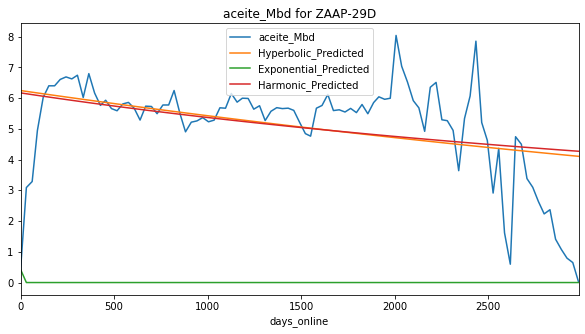

Exponential Fit Curve-fitted Variables: qi=0.9503702011962538, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.7964619999999996, b=1.2316743762050275e-12, di=4.586755371671948e-23
Harmonic Fit Curve-fitted Variables: qi=3.7964619999999814, di=7.709663790751512e-18


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


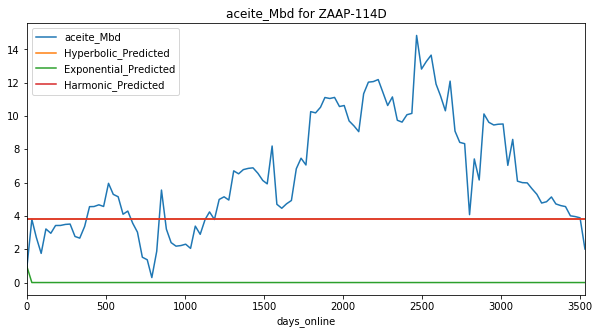

Exponential Fit Curve-fitted Variables: qi=0.4118283876436504, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.348233755988011, b=5.766618833930364e-16, di=0.00043694924229245244
Harmonic Fit Curve-fitted Variables: qi=5.675513645798548, di=0.0006942292625674753


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


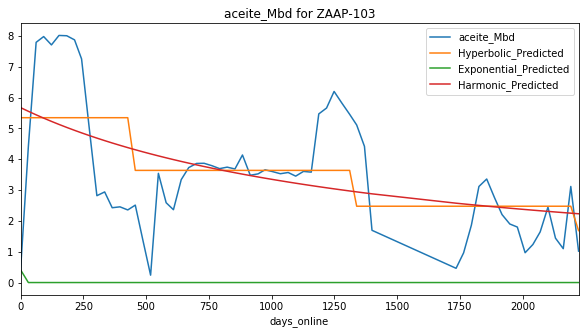

Exponential Fit Curve-fitted Variables: qi=1.428398003151143, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.162188999999999, b=1.34901796217573e-13, di=0.0003830690353093693
Harmonic Fit Curve-fitted Variables: qi=6.162188999999996, di=0.0005167843337019136


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


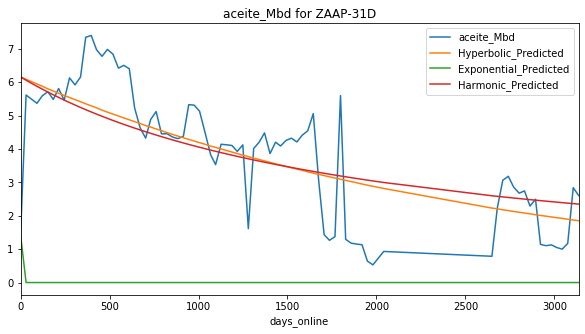

Exponential Fit Curve-fitted Variables: qi=2.5151973515624997, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.517655999999915, b=1.9999999999999998, di=9.943180791135565e-16
Harmonic Fit Curve-fitted Variables: qi=2.5176559999999966, di=6.576965188637108e-18


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


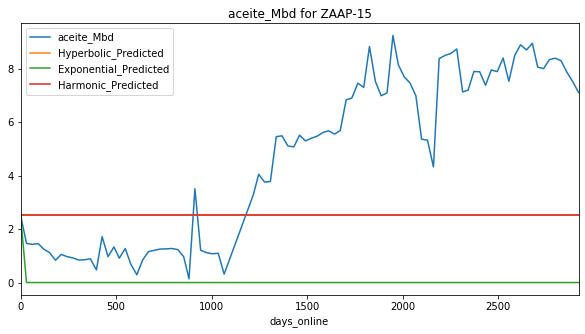

Exponential Fit Curve-fitted Variables: qi=1.7691760007749675, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.12186345461269, b=1.9970291510768166, di=1.454773411081795e-22
Harmonic Fit Curve-fitted Variables: qi=6.121864455379311, di=7.572353359452334e-25


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


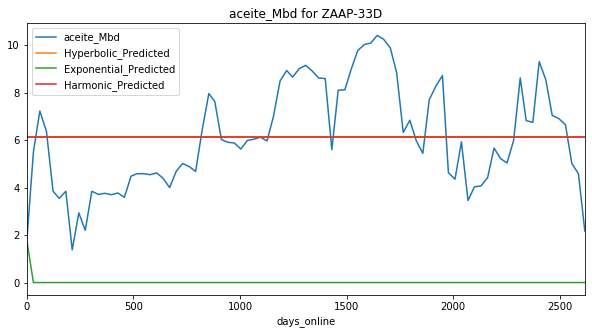

Exponential Fit Curve-fitted Variables: qi=3.0697159995778733, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.348270473515314, b=5.430248360053288e-06, di=1.976437822114229e-14
Harmonic Fit Curve-fitted Variables: qi=2.3482704492009323, di=6.372813014480199e-15


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


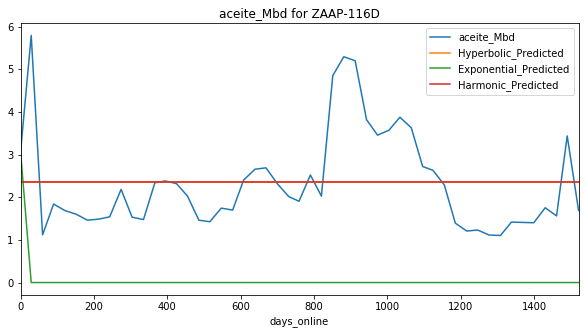

Exponential Fit Curve-fitted Variables: qi=0.43822221871711264, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.2464320089530347, b=1.9638472740089954e-10, di=0.00028982023231831
Harmonic Fit Curve-fitted Variables: qi=3.283003783650349, di=0.000363417150705091


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


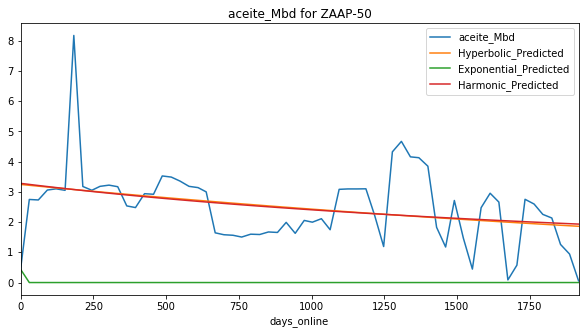

Exponential Fit Curve-fitted Variables: qi=0.34892400812699903, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.5250044661632662, b=1.466087461883251, di=3.0142172919644954e-14
Harmonic Fit Curve-fitted Variables: qi=2.5250044381664853, di=6.966895309354951e-15


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


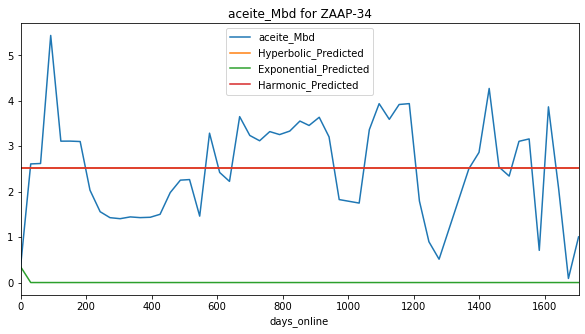

Exponential Fit Curve-fitted Variables: qi=0.12505672583193833, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.713693807647057, b=1.9999999999999998, di=1.459031431584544e-22
Harmonic Fit Curve-fitted Variables: qi=6.713693804877454, di=1.765928730976314e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


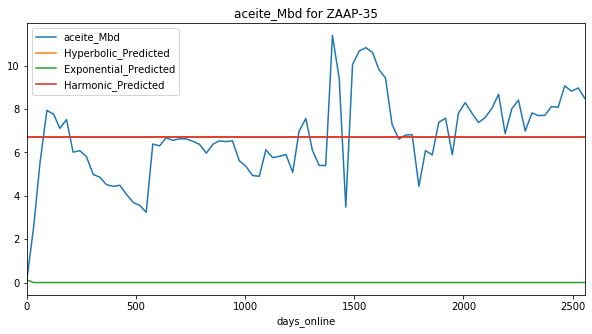

Exponential Fit Curve-fitted Variables: qi=2.302086019559447, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.7400767515340405, b=1.9994043061604385, di=1.4167538118412953e-20
Harmonic Fit Curve-fitted Variables: qi=2.740076515680295, di=7.618912190868004e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


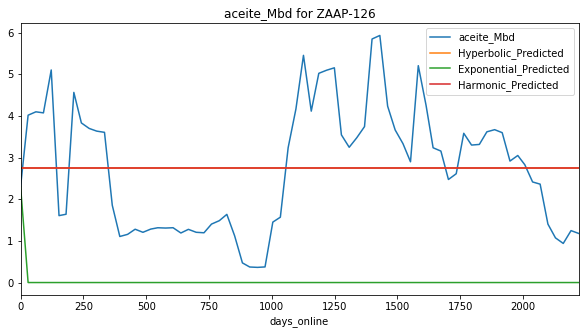

Exponential Fit Curve-fitted Variables: qi=0.5797671510816957, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.4976629999999975, b=1.9999999999999998, di=1.6665379053342041e-21
Harmonic Fit Curve-fitted Variables: qi=5.497662999999365, di=2.869822504530051e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


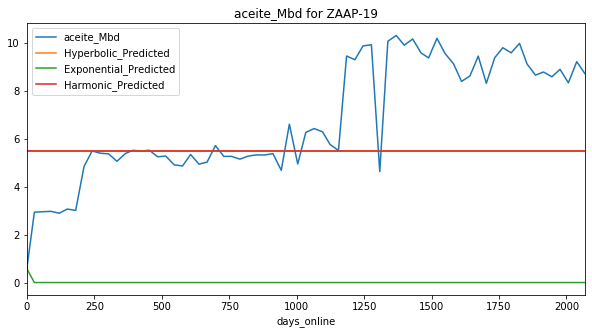

Exponential Fit Curve-fitted Variables: qi=2.356376169394515, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.8037496678541807, b=4.058568848996913e-06, di=4.164415610125975e-18
Harmonic Fit Curve-fitted Variables: qi=3.8037496668339195, di=9.06806382389911e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


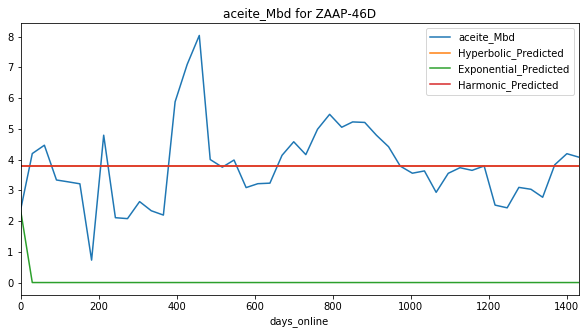

Exponential Fit Curve-fitted Variables: qi=3.431987730325971, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.908434957826029, b=7.453475737195565e-08, di=3.763695888262807e-05
Harmonic Fit Curve-fitted Variables: qi=5.900799265174513, di=3.6200246847426254e-05


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


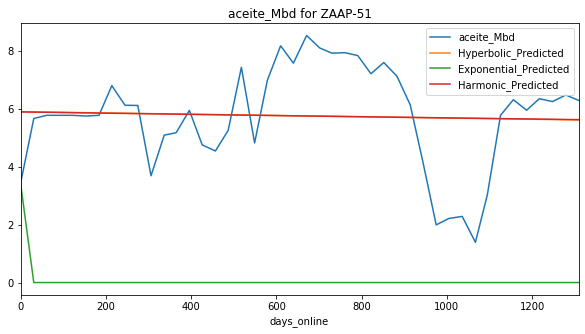

Exponential Fit Curve-fitted Variables: qi=1.4392401465050209, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.7776544575086755, b=1.9913464032124344, di=1.9977266364616244e-19
Harmonic Fit Curve-fitted Variables: qi=7.777653778500662, di=3.7530896843210855e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


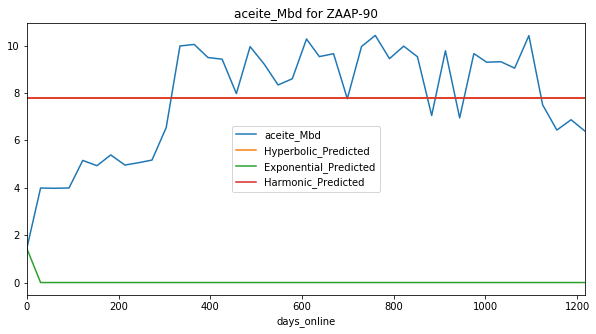

Exponential Fit Curve-fitted Variables: qi=0.3602731187490415, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.388002252373021, b=0.009058315667509816, di=3.998345981195724e-06
Harmonic Fit Curve-fitted Variables: qi=6.386153241122745, di=3.515206921317086e-06


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


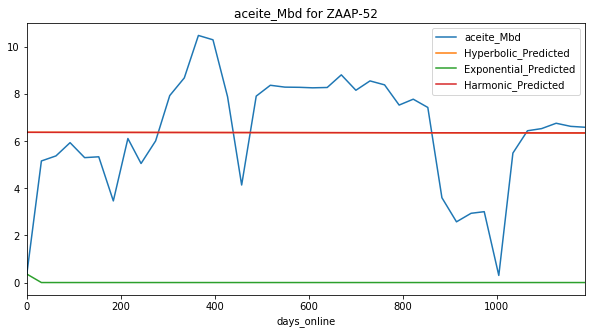

Exponential Fit Curve-fitted Variables: qi=0.1661774339819636, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.381005587728999, b=2.347097293303652e-13, di=0.0004677098631276849
Harmonic Fit Curve-fitted Variables: qi=5.2099535918860935, di=0.00046460681865853214


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


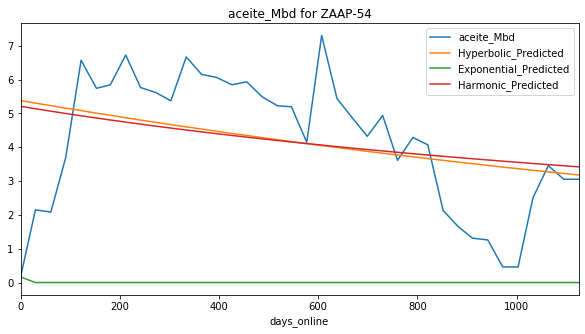

Exponential Fit Curve-fitted Variables: qi=2.1833574984748005, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.87379151240031, b=1.9132294327706134e-05, di=9.147246887992898e-18
Harmonic Fit Curve-fitted Variables: qi=6.87379147449999, di=4.1261495264533392e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


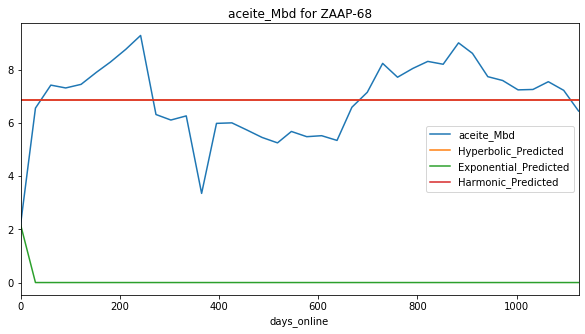

Exponential Fit Curve-fitted Variables: qi=1.8306919337840997, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.717765907972422, b=1.9999999999999998, di=1.2375932369041949e-20
Harmonic Fit Curve-fitted Variables: qi=5.717765907951661, di=1.6681861939711707e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


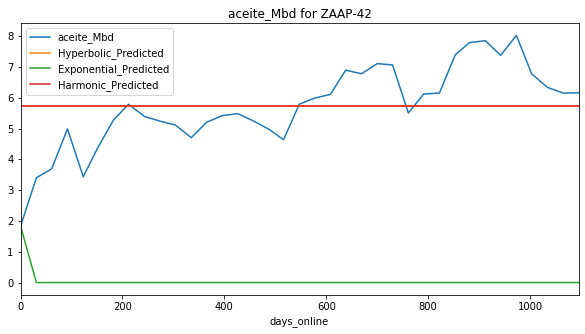

Exponential Fit Curve-fitted Variables: qi=1.7021130279970367, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.316059122146608, b=9.022328861536116e-08, di=0.0002590299874102908
Harmonic Fit Curve-fitted Variables: qi=3.323458613405534, di=0.0002881392087218422


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


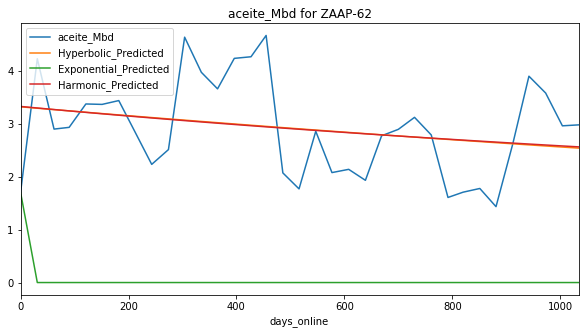

Exponential Fit Curve-fitted Variables: qi=6.204652165971509, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.915020125722709, b=1.9999999999969722, di=0.0007074428015616771
Harmonic Fit Curve-fitted Variables: qi=7.722548552913769, di=0.0005262614551500828


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


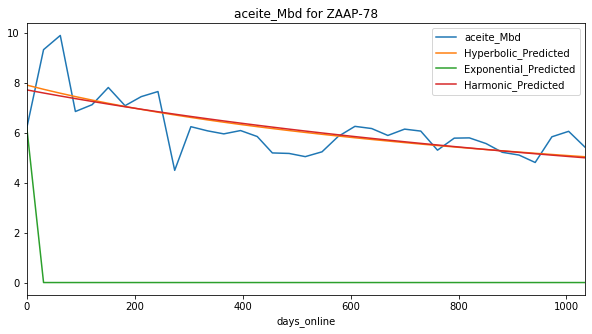

Exponential Fit Curve-fitted Variables: qi=2.0260908473106682, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.137159037158453, b=1.2827332251941215e-06, di=1.0733834340906101e-21
Harmonic Fit Curve-fitted Variables: qi=5.137158999629629, di=1.3237855622029234e-23


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


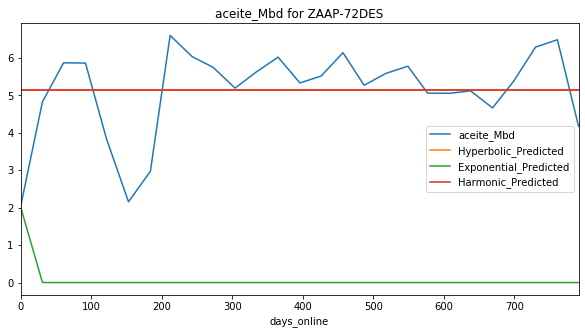

Exponential Fit Curve-fitted Variables: qi=0.9070634621312763, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=3.601776873262777, b=5.161163474263218e-08, di=0.0025495508853280815
Harmonic Fit Curve-fitted Variables: qi=3.5270251416397183, di=0.0036979550961303903


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


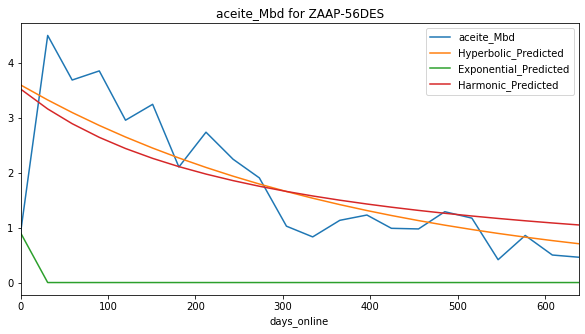

Exponential Fit Curve-fitted Variables: qi=0.8427340016887411, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=7.8292195047669795, b=3.752296078729435e-07, di=0.000615476483144386
Harmonic Fit Curve-fitted Variables: qi=7.669080199684384, di=0.0006092957474973389


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


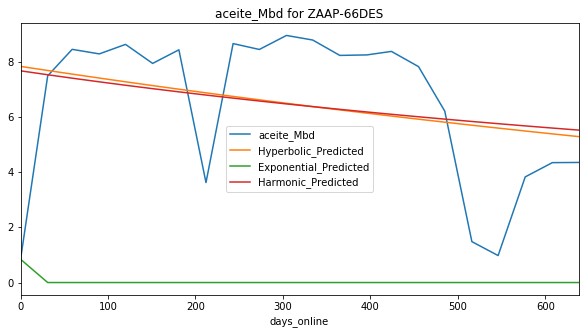

Exponential Fit Curve-fitted Variables: qi=2.6551622648776956, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.28443406273244, b=2.2780554044032897e-05, di=3.556292823679406e-15
Harmonic Fit Curve-fitted Variables: qi=6.2844340887365355, di=9.456691612267375e-18


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


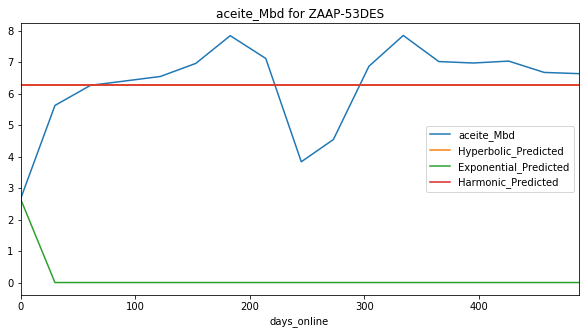

Exponential Fit Curve-fitted Variables: qi=4.1201418609661795, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=6.052963590625, b=1.9999999999999998, di=4.5390477904274694e-21
Harmonic Fit Curve-fitted Variables: qi=6.052963590625, di=4.984958441121146e-22


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


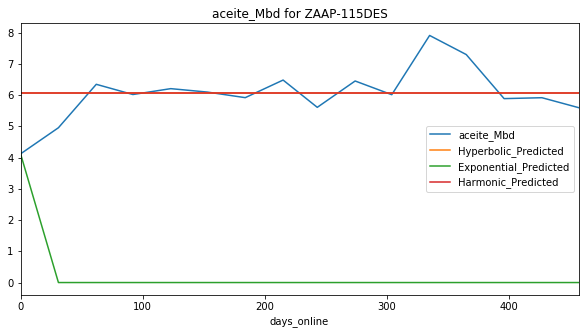

Exponential Fit Curve-fitted Variables: qi=3.598924252974459, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.964674821543993, b=1.0515136641187084e-05, di=3.4565698122746987e-16
Harmonic Fit Curve-fitted Variables: qi=5.964674830799981, di=1.0515404572837401e-19


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


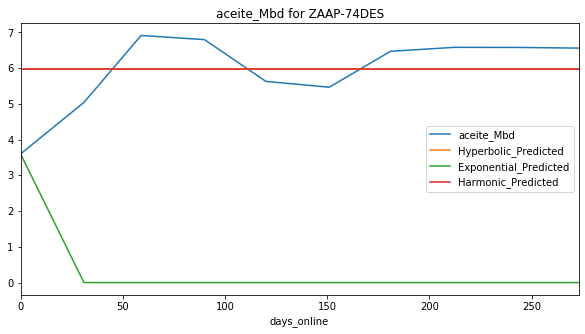

Exponential Fit Curve-fitted Variables: qi=0.26042788175670867, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.36044830366589836, b=1.9999999999999998, di=3.902948607249689e-19
Harmonic Fit Curve-fitted Variables: qi=0.3604483036666535, di=8.517409145750475e-20


C:\Users\elias\Anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


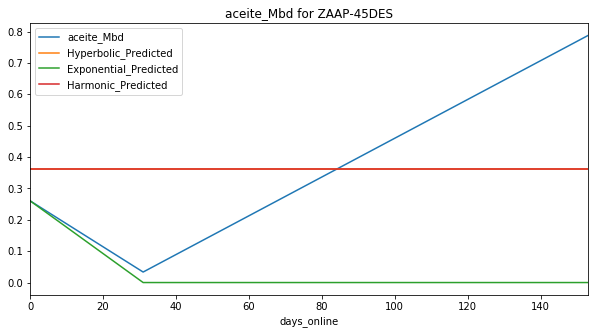

Exponential Fit Curve-fitted Variables: qi=3.792676821115055, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=5.180310012499996, b=1.9999999999999998, di=9.313203822784017e-21
Harmonic Fit Curve-fitted Variables: qi=5.180310012494923, di=9.6360849073806e-17


C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


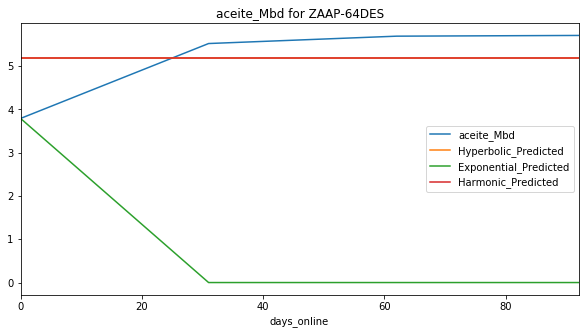

Exponential Fit Curve-fitted Variables: qi=1.078328550026818, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=2.9511138673911432, b=1.999999999203889, di=4.450191383056763e-17
Harmonic Fit Curve-fitted Variables: qi=2.951151445332298, di=1.0383388619872231e-17


C:\Users\elias\Anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


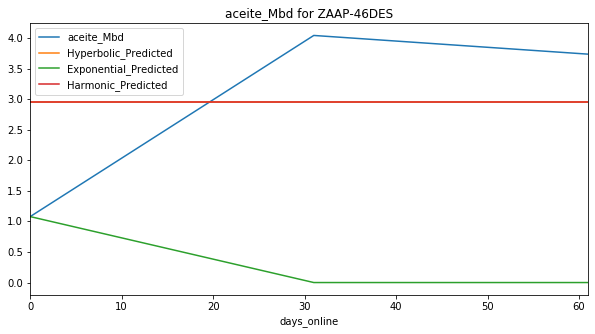

'Tiempo de procesamiento: 116.17763429999968 segundos'

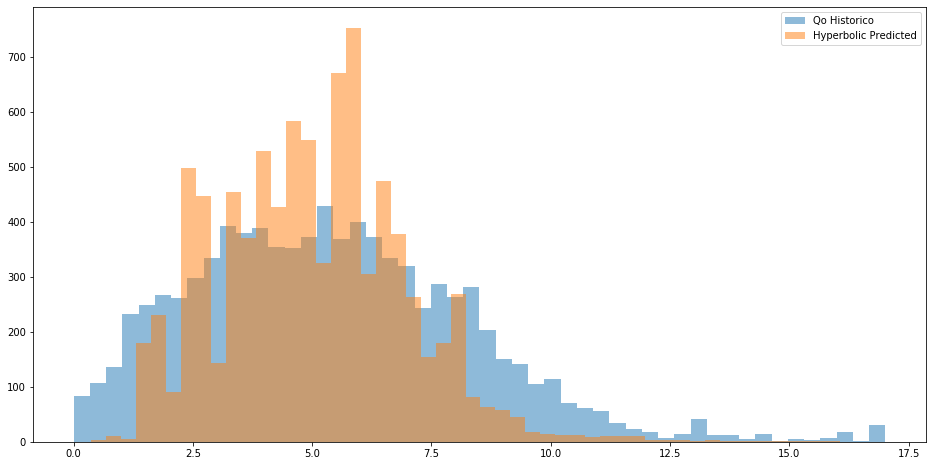

In [16]:
productividad()

In [ ]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    global z_score
    global outliers
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return z_score

In [152]:
score=[]
def outlier_filter(data):
    global score
    global outliers
    threshold=3
    mean_1 = np.mean(data)
    std_1 =np.std(data)
    
    
    for y in data:
        z = (y - mean_1)/std_1 
        score.append(z)
    return score

In [153]:
df=campo
outliers=outlier_filter(df.aceite_Mbd)


In [154]:
display(score)

[-1.6806690065158356,
 -1.388330809107517,
 -0.9173180363450323,
 -1.8328773496031123,
 -0.9101129546202659,
 -0.9101126096979754,
 -0.7223827894531829,
 -0.9101129546202659,
 -0.6411401380878823,
 -1.0103239175031156,
 -0.5409422822520686,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.0561295976720557,
 -0.4950676176250429,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.0561295976720557,
 -0.4950676176250429,
 -1.0561261484491513,
 -0.49504899182135975,
 -1.055503218792637,
 -0.49404768241224506,
 -0.8913502167878123,
 -0.9163325933612774,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919171585007,
 -1.1574443118842777,
 -0.7907922620807912,
 -1.157444656806568,
 -0.7907919

In [160]:
selected_row=score<=3

TypeError: '<=' not supported between instances of 'list' and 'int'